<a href="https://colab.research.google.com/github/mille055/stanford_project/blob/dockerversion/app/notebooks/Stanford_CS231N.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
COLAB_FLAG = True   # whether running on colab or locally on computer

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
if COLAB_FLAG:
  %pip install pydicom==2.1.2
  %pip install monai seaborn sentence_transformers
  !git clone -b dockerversion 'https://github.com/mille055/stanford_project.git'
  

    

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 68.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 121.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 88.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 94.1 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=d24ed5defb1c536e105be3f01b4636e82946147e62ba74ad8e9da3b75bf20405
  Stored in directory:

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import torchvision
import pydicom
import pickle
import glob
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

import seaborn as sns
from datetime import datetime

from sentence_transformers import SentenceTransformer

from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import time
import os
import copy
from pprint import pprint
from fastai.basics import delegates
from fastcore.parallel import parallel
from fastcore.utils import gt
from fastcore.foundation import L

from pydicom.dataset import Dataset as DcmDataset
from pydicom.tag import BaseTag as DcmTag
from pydicom.multival import MultiValue as DcmMultiValue
import sys
import importlib
import warnings
from google.colab import drive
warnings.filterwarnings("ignore")

In [5]:
#local imports
if COLAB_FLAG:
    sys.path.append('/content/stanford_project/app/scripts/')
    train_datafile = '/content/stanford_project/app/data/trainfiles.csv'
    val_datafile = '/content/stanford_project/app/data/valfiles.csv'
    test_datafile = '/content/stanford_project/app/data/testfiles.csv'
    
    drive.mount('/content/gdrive')

else: # running locally
    sys.path.append('/Users/cmm/Documents/GitHub/new/stanford_project/app/scripts/')
    #sys.path.append('/workspaces/stanford_project/app/scripts/')
    train_datafile = '../data/trainfiles.csv'
    val_datafile = '../data/valfiles.csv'
    test_datafile = '../data/testfiles.csv'


### local imports ###
from config import file_dict, feats, feats_to_keep, column_lists, RF_parameters, classes, model_paths
from config import abd_label_dict, val_list, train_val_split_percent, random_seed, data_transforms
from config import sentence_encoder, series_description_column
from utils import *

from cnn.cnn_dataset import ImgDataset
from cnn.cnn_inference import image_to_tensor, pixel_inference, test_pix_model, load_pixel_model, visualize_results
from cnn.cnn_model import *
from cnn.cnn_training import *
from cnn.cnn_data_loaders import get_data_loaders, data_transforms, data_transforms2

from model_container import ModelContainer



Mounted at /content/gdrive


In [ ]:


train_df, val_df, test_df = create_datasets(train_datafile, val_datafile, test_datafile, '/volumes/cm7/Abdominal_MRI_dataset_split/', '/content/gdrive/MyDrive/WW_MRI_abd2/split/' )



In [6]:
train_df = pd.read_pickle('/content/gdrive/MyDrive/train_df.pkl')
val_df = pd.read_pickle('/content/gdrive/MyDrive/val_df.pkl')
test_df = pd.read_pickle('/content/gdrive/MyDrive/test_df.pkl')

In [7]:
sorted(val_df.label.unique())

[0, 2, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 23, 25]

In [8]:
# Get the data loaders
batch_size = 16
train_loader, val_loader, test_loader, dataset_sizes = get_data_loaders(train_df, val_df, test_df, batch_size)
train_loader2, val_loader2, test_loader2, dataset_sizes2 = get_data_loaders(train_df, val_df, test_df, batch_size, data_transforms=data_transforms2)
dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataloaders2 = {'train': train_loader2, 'val': val_loader2, 'test': test_loader2}

In [9]:
# Different combinations to evaluate
models = [CustomResNet50, CustomResNet50b, CustomDenseNet]
loss_funcs = [nn.CrossEntropyLoss, FocalLoss]
loaders = ['dataloaders', 'dataloaders2']
loaders_dict = {'dataloaders': dataloaders, 'dataloaders2': dataloaders2}
optimizers = ['SGD', 'Adam']
optim_dict = {
    'SGD': {
        'class': torch.optim.SGD,
        'params': {'lr': 0.001, 'momentum': 0.9}
    },
    'Adam': {
        'class': torch.optim.Adam,
        'params': {'lr': 0.001, 'betas': (0.9, 0.999)}
    }
}


In [ ]:
# perform several training runs to compare accuracy on the validation dataset
best_model = None
best_accuracy = -1

for model_class in models:
  for loader in loaders:
        for opt in optimizers:
            for loss_func_class in loss_funcs:
                print(f"\nTraining with {model_class.__name__}, {loaders_dict[loader]}, {opt}, {loss_func_class.__name__}")

                # Instantiate the custom model
                num_classes = len(classes)
                model = model_class(num_classes)
                model = model.to(device)  # Move the model to the appropriate device

                # Define loss function 
                criterion = loss_func_class()
               
                # Instantiate the selected optimizer with its parameters
                opt_class = optim_dict[opt]['class']
                opt_params = optim_dict[opt]['params']
                optimizer = opt_class(model.parameters(), **opt_params)
               
                #optimizer = opt_class(model.parameters(), lr=0.001, momentum=0.9)

                # Decay LR by a factor of 0.1 every 7 epochs
                exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

                # Select the dataloader
                dataloaders = loaders_dict[loader]

                # Train the model
                trained_model, best_val_accuracy, history = train_cnn_model(model, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=15)

                # Print the history data
                print("Training loss history:", history['train_loss'])
                print("Validation loss history:", history['val_loss'])
                print("Training accuracy history:", history['train_acc'])
                print("Validation accuracy history:", history['val_acc'])


                # Plot training curves
                combination_name = f"{model_class.__name__}_{loaders_dict[loader]}_{opt}_{loss_func_class.__name__}"
                plot_training_curves(history, combination_name)

                if best_val_accuracy > best_accuracy:
                  best_model = trained_model
                  best_accuracy = best_val_accuracy
               


Training with CustomResNet50, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f1661bfe650>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f166a65aaa0>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f166a65b2b0>}, SGD, CrossEntropyLoss


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 369MB/s]


Epoch 0/14
----------


In [ ]:
def display_and_save_results2(y_pred, y_true, classes=classes, fn='', saveflag = True):
   

    classes_raw_list = np.unique(np.concatenate((y_true, y_pred)))
    print(classes_raw_list)
    classes_list = [classes[x] for x in classes_raw_list]
    print(classes_list)
    y_true = [classes[x] for x in y_true]
    y_pred = [classes[x] for x in y_pred]
    # Generate a confusion matrix based on the true labels and predicted labels
    cm = confusion_matrix(y_true = y_true, y_pred = y_pred, labels=classes_list)
  
    #mask = np.all(cm == 0, axis=1)

    class_text_labels = np.array([abd_label_dict[str(x)]['short'] for x in classes_list])
    #class_text_labels = class_text_labels[~mask]

     # Generate a classification report based on the true labels and predicted labels
    print(classification_report(y_true, y_pred))

    
    #cm = cm[~mask]
    # Create a ConfusionMatrixDisplay object with the correct labels
    cm_display = ConfusionMatrixDisplay(cm, display_labels=class_text_labels).plot(xticks_rotation = 'vertical', cmap='Blues')
    plt.figure(figsize=(25, 25))
    plt.tight_layout()
    #ConfusionMatrixDisplay(cm, display_labels=class_text_labels).plot(xticks_rotation = 'vertical', cmap='Blues')
    if saveflag:
        plt.savefig("/content/FigCM_"+fn+datetime.today().strftime('%Y%m%d')+".tif",dpi=300, bbox_inches = 'tight')     

    return cm      



[ 0  1  2  3  4  5  7  8  9 10 12 13 14 15 17 18]
[0, 2, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 23, 25]
              precision    recall  f1-score   support

           0       0.81      1.00      0.89        17
           2       0.90      0.92      0.91        49
           6       0.88      1.00      0.93        14
           7       0.95      1.00      0.97        18
           8       0.97      0.91      0.94        35
           9       0.92      0.97      0.94        34
          11       1.00      0.95      0.97        20
          12       0.00      0.00      0.00        12
          13       1.00      0.33      0.50         3
          14       0.95      0.95      0.95        19
          16       0.50      0.75      0.60        20
          17       1.00      0.94      0.97        17
          18       1.00      0.91      0.95        22
          19       1.00      0.95      0.97        19
          23       0.60      0.47      0.53        19
          25       0.85   

RuntimeError: ignored

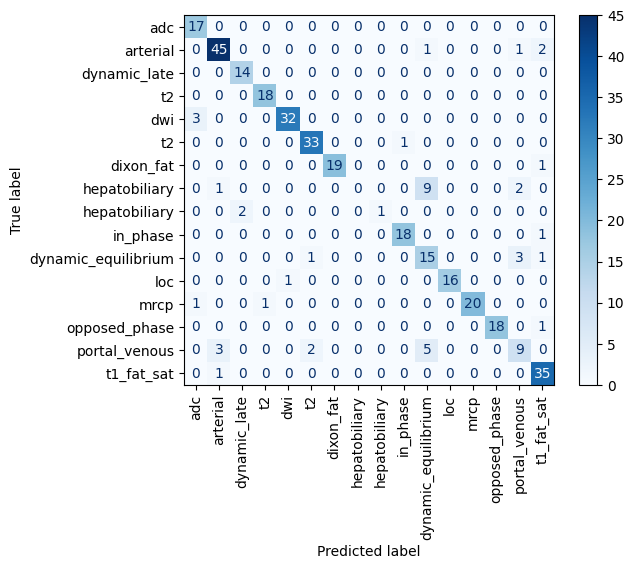

<Figure size 2500x2500 with 0 Axes>

In [ ]:
# Evaluate the model on the val dataset
model = best_model

model.eval()
val_predictions = []
val_labels = []

for inputs, labels in val_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad(): # No need to calculate gradients when doing inference
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1) # Get class from network's prediction
        val_predictions.append(predicted.cpu().numpy())
        val_labels.append(labels.cpu().numpy())
val_predictions = np.concatenate(val_predictions, axis=0)
val_labels = np.concatenate(val_labels, axis=0)

#print(val_predictions)
#print(val_labels)
cm = display_and_save_results2(val_predictions, val_labels, classes, fn='DenseNetFL', saveflag=True)

# Save the trained model if needed
save_filename = f"cnn_model_{combination_name}_{datetime.now().strftime('%Y%m%d')}.pth"
torch.save(trained_model.state_dict(), '/content/gdrive/MyDrive/model0530a.pth')



# model.eval()
# val_predictions = []
# test_labels = []

# for inputs, labels in test_loader:
#     inputs = inputs.to(device)
#     labels = labels.to(device)
#     print(labels)
#     with torch.no_grad(): # No need to calculate gradients when doing inference
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs, 1) # Get class from network's prediction
#         test_predictions.append(predicted.cpu().numpy())
#         test_labels.append(labels.cpu().numpy())

# print (test_predictions)
# print(test_labels)


# test_predictions = np.concatenate(test_predictions, axis=0)
# test_labels = np.concatenate(test_labels, axis=0)


# accuracy = np.sum(test_predictions==test_labels)/len(test_labels)
# print('Accuracy on the test dataset is ', np.round(accuracy, 3))
# #results = make_results_df(preds, true, test)

# # Save the trained model if needed
# save_filename = f"cnn_model_{combination_name}_{datetime.now().strftime('%Y%m%d')}.pth"
# torch.save(trained_model.state_dict(), save_filename)


In [ ]:
torch.save(trained_model.state_dict(), '/content/model0529a.pth')


In [ ]:
!pip install transformers
from transformers import DeiTFeatureExtractor, DeiTForImageClassification



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
deit_model = DeiTForImageClassification.from_pretrained('facebook/deit-base-distilled-patch16-224')
feature_extractor = DeiTFeatureExtractor.from_pretrained('facebook/deit-base-distilled-patch16-224')
batch_size = 16

optimizer = optim.Adam(deit_model.parameters(), lr=0.001, betas=(0.9,0.99))
criterion = FocalLoss()


def normalize_image(image):
    min_val = image.min()
    max_val = image.max()
    if min_val != max_val:
        image = (image - min_val) / (max_val - min_val)
    else:
        # Avoid zero division and return a zero image.
        image = torch.zeros_like(image)
    return image

class ImgDataset_deit(Dataset):
    def __init__(self, df, transform=None):
        self.data_df = df
        self.datafileslist = df.fname
        self.labels = df.label
        self.transform = transform
        
        
    def __len__(self):
        return self.data_df.shape[0]
    
    def __getitem__(self, idx):
      source = file_dict['img_data_dir_local']
      dest = file_dict['img_data_dir_colab']

      img_file = self.data_df.fname[idx]
      ds = pydicom.dcmread(img_file)
      img = ds.pixel_array.astype(np.float32)  # Convert to float
      img = (img - np.min(img)) / (np.max(img) - np.min(img))  # Normalize here
      img = torch.from_numpy(img)  # Convert to torch tensor
      img = img.repeat(3, 1, 1)  # Convert to 3-channel image

      if self.transform:
        img = self.transform(img)

      img = img[np.newaxis]
      # Apply feature extractor directly here
      img = feature_extractor(images=img, return_tensors="pt")["pixel_values"]
    

      labl = self.data_df.label[idx]
      adjusted_label = classes.index(labl)
      y = torch.tensor(adjusted_label, dtype=torch.long) 

      return (img, y)



deit_transforms = {
    'train': transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize((224, 224)),
      transforms.Grayscale(num_output_channels=3),
      #transforms.Lambda(normalize_image),  # min-max normalization
      transforms.ToTensor()
]),
    'val': transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize((224, 224)),
      transforms.Grayscale(num_output_channels=3),
      #transforms.Lambda(normalize_image),  # min-max normalization
      transforms.ToTensor()
    ]),

    'test': transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize((224, 224)),
      transforms.Grayscale(num_output_channels=3),
      #transforms.Lambda(normalize_image),  # min-max normalization
      transforms.ToTensor()
    ])
}

def get_data_loaders_deit(train, val, test, batch_size, data_transforms = deit_transforms, shuffle=True, num_workers=0):
    # Create instances of your custom dataset
    train_imgdata = ImgDataset_deit(train, data_transforms['train'])
    val_imgdata = ImgDataset_deit(val, data_transforms['val'])
    test_imgdata = ImgDataset_deit(test, data_transforms['test'])

    # Create data loaders for the training, validation, and test datasets
    train_loader = DataLoader(train_imgdata, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    val_loader = DataLoader(val_imgdata, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    test_loader = DataLoader(test_imgdata, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    dataset_sizes = {'train': len(train_imgdata), 'val': len(val_imgdata)}

    return train_loader, val_loader, test_loader, dataset_sizes








train_loader_deit, val_loader_deit, test_loader_deit, dataset_sizes_deit = get_data_loaders(train_df, val_df, test_df, batch_size, data_transforms=deit_transforms)



Some weights of the model checkpoint at facebook/deit-base-distilled-patch16-224 were not used when initializing DeiTForImageClassification: ['distillation_classifier.bias', 'cls_classifier.bias', 'cls_classifier.weight', 'distillation_classifier.weight']
- This IS expected if you are initializing DeiTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DeiTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream t

In [ ]:
def calc_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels.data)


In [ ]:
def train_deit_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    val_acc_history = []
    train_acc_history = []
    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval()  

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs.logits, labels)
                    _, preds = torch.max(outputs.logits, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            else:
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

        print()

    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history


In [ ]:
deit_model = deit_model.to(device)
deit_model, train_acc, val_acc, train_loss, val_loss = train_deit_model(deit_model, {'train': train_loader_deit, 'val': val_loader_deit}, criterion, optimizer, num_epochs=25)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.show()


Epoch 0/24
----------
train Loss: 6.8861 Acc: 0.0000
val Loss: 6.8773 Acc: 0.0000

Epoch 1/24
----------
train Loss: 6.8861 Acc: 0.0000
val Loss: 6.8773 Acc: 0.0000

Epoch 2/24
----------
train Loss: 6.8861 Acc: 0.0000
val Loss: 6.8773 Acc: 0.0000

Epoch 3/24
----------
train Loss: 6.8861 Acc: 0.0000
val Loss: 6.8773 Acc: 0.0000

Epoch 4/24
----------
train Loss: 6.8861 Acc: 0.0000
val Loss: 6.8773 Acc: 0.0000

Epoch 5/24
----------
train Loss: 6.8861 Acc: 0.0000
val Loss: 6.8773 Acc: 0.0000

Epoch 6/24
----------
train Loss: 6.8861 Acc: 0.0000
val Loss: 6.8773 Acc: 0.0000

Epoch 7/24
----------
train Loss: 6.8861 Acc: 0.0000
val Loss: 6.8773 Acc: 0.0000

Epoch 8/24
----------
train Loss: 6.8861 Acc: 0.0000
val Loss: 6.8773 Acc: 0.0000

Epoch 9/24
----------
train Loss: 6.8861 Acc: 0.0000
val Loss: 6.8773 Acc: 0.0000

Epoch 10/24
----------
train Loss: 6.8861 Acc: 0.0000
val Loss: 6.8773 Acc: 0.0000

Epoch 11/24
----------
train Loss: 6.8861 Acc: 0.0000
val Loss: 6.8773 Acc: 0.0000

Ep

In [ ]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load pre-trained DeiT model and adjust the classifier for your number of classes
deit_model = DeiTForImageClassification.from_pretrained('facebook/deit-base-distilled-patch16-224')
num_classes = len(classes) # classes is your list of classes
deit_model.classifier = torch.nn.Linear(in_features=model.classifier.in_features, out_features=num_classes)
deit_model.to(device)

# Define your loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(deit_model.parameters(), lr=0.001)

num_epochs = 20

# Start training
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader_deit, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = deit_model(inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0


Some weights of the model checkpoint at facebook/deit-base-distilled-patch16-224 were not used when initializing DeiTForImageClassification: ['distillation_classifier.bias', 'cls_classifier.bias', 'cls_classifier.weight', 'distillation_classifier.weight']
- This IS expected if you are initializing DeiTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DeiTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream t

In [ ]:
running_loss

60.25002270936966